# Tutorial 8 - Options

Please complete this tutorial to get an overview of options and an implementation of SMDP Q-Learning and Intra-Option Q-Learning.


### References:

 [Recent Advances in Hierarchical Reinforcement
Learning](https://people.cs.umass.edu/~mahadeva/papers/hrl.pdf) is a strong recommendation for topics in HRL that was covered in class. Watch Prof. Ravi's lectures on moodle or nptel for further understanding the core concepts. Contact the TAs for further resources if needed. 


In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
from tqdm import tqdm
import random
import gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
'''
The environment used here is extremely similar to the openai gym ones.
At first glance it might look slightly different. 
The usual commands we use for our experiments are added to this cell to aid you
work using this environment.
'''

#Setting up the environment
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv
env = CliffWalkingEnv()
env.reset()

#Current State
print(env.s)

# 4x12 grid = 48 states
print ("Number of states:", env.nS)

# Primitive Actions
action = ["up", "right", "down", "left"]
#correspond to [0,1,2,3] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.nA)

# Example Transitions
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob, _ = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
# env.render()

36
Number of states: 48
Number of actions that an agent can take: 4
Action taken: up
Transition probability: False
Next state: 24
Reward recieved: -1
Terminal state: False


#### Options
We custom define very simple options here. They might not be the logical options for this settings deliberately chosen to visualise the Q Table better.


In [3]:
# We are defining two more options here
# Option 1 ["Away"] - > Away from Cliff (ie keep going up)
# Option 2 ["Close"] - > Close to Cliff (ie keep going down) 

def Away(env,state):
    
    optdone = False
    optact = 0
    
    if (int(state/12) == 0):
        optdone = True
    
    return [optact,optdone]
    
def Close(env,state):
    
    optdone = False
    optact = 2
    
    if (int(state/12) == 2):
        optdone = True
        
    if (int(state/12) == 3):
        optdone = True
    
    return [optact,optdone]
    
    
'''
Now the new action space will contain
Primitive Actions: ["up", "right", "down", "left"]
Options: ["Away","Close"]
Total Actions :["up", "right", "down", "left", "Away", "Close"]
Corresponding to [0,1,2,3,4,5]
'''

'\nNow the new action space will contain\nPrimitive Actions: ["up", "right", "down", "left"]\nOptions: ["Away","Close"]\nTotal Actions :["up", "right", "down", "left", "Away", "Close"]\nCorresponding to [0,1,2,3,4,5]\n'

# Task 1
Complete the code cell below


In [4]:
# Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
q_values = np.zeros((48, 6))

# Update_Frequency Data structure? Check TODO 4
update_freq = np.zeros((48, 6))

# TODO: epsilon-greedy action selection function
def egreedy_policy(q_values, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(0, 6)
    else:
        return np.argmax(q_values[state])

# Task 2
Below is an incomplete code cell with the flow of SMDP Q-Learning. Complete the cell and train the agent using SMDP Q-Learning algorithm.
Keep the **final Q-table** and **Update Frequency** table handy (You'll need it in TODO 4)

In [5]:
#### SMDP Q-Learning

# Add parameters you might need here
gamma = 0.9
alpha = 0.1

q_values_SMDP = np.zeros((48, 6))
update_freq_SMDP = np.zeros((48, 6))


# Iterate over 1000 episodes
for _ in tqdm(range(1000)):
    state, _ = env.reset()
    done = False

    # While episode is not over
    while not done:

        # Choose action
        action = egreedy_policy(q_values_SMDP, state, epsilon=0.1)

        # Checking if primitive action
        if action < 4:
            next_state, reward, done, _, _ = env.step(action)
            # Perform regular Q-Learning update for state-action pair
            q_values_SMDP[state, action] += alpha * (
                reward
                + gamma * np.max(q_values_SMDP[next_state])
                - q_values_SMDP[state, action]
            )
            update_freq_SMDP[state, action] += 1
            state = next_state

        # Checking if action chosen is an option
        if action == 4 or action == 5:

            Option = Away if action == 4 else Close
            reward_bar = 0
            optdone = False
            init_state = state

            while not optdone and not done:

                # This function goes Away or Close based on the action chosen
                optact, optdone = Option(env, state)
                next_state, reward, done, _, _ = env.step(optact)

                # reward_bar -> return of the option, starting from initial_state
                reward_bar = gamma * reward_bar + reward
                state = next_state

            # Complete SMDP Q-Learning update
            # We update only the initial state-action pair, on exiting the option
            q_values_SMDP[init_state, action] += alpha * (
                reward_bar
                + gamma * np.max(q_values_SMDP[state])
                - q_values_SMDP[init_state, action]
            )

100%|██████████| 1000/1000 [00:00<00:00, 1585.92it/s]


# Task 3
Using the same options and the SMDP code, implement Intra Option Q-Learning (In the code cell below). You *might not* always have to search through options to find the options with similar policies, think about it. Keep the **final Q-table** and **Update Frequency** table handy (You'll need it in TODO 4)



In [6]:
# Intra Option Q-Learning

# Add parameters you might need here
gamma = 0.9
alpha = 0.1
q_values_IOQL = np.zeros((48, 6))
update_freq_IOQL = np.zeros((48, 6))

# Iterate over 1000 episodes
for _ in tqdm(range(1000)):

    state, _ = env.reset()
    done = False

    # While episode is not over
    while not done:

        # Choose action
        action = egreedy_policy(q_values_IOQL, state, epsilon=0.1)

        # Checking if primitive action
        if action < 4:
            next_state, reward, done, _, _ = env.step(action)
            # Perform regular Q-Learning update for state-action pair
            q_values_IOQL[state, action] += alpha * (
                reward
                + gamma * np.max(q_values_IOQL[next_state])
                - q_values_IOQL[state, action]
            )
            update_freq_IOQL[state, action] += 1
            state = next_state

        # Checking if action chosen is an option
        if action == 4 or action == 5:

            Option = Away if action == 4 else Close
            reward_bar = 0
            optdone = False

            while not optdone and not done:

                optact, optdone = Option(env, state)
                next_state, reward, done, _, _ = env.step(optact)

                if optdone or done:         
                    # If option is done or episode is over, use regular Q-Learning update
                    q_values_IOQL[state, action] += alpha * (
                        reward
                        + gamma * np.max(q_values_IOQL[next_state])
                        - q_values_IOQL[state, action]
                    )
                else:                       
                    # If option is not done, use intra-option Q-Learning update
                    q_values_IOQL[state, action] += alpha * (
                        reward
                        + gamma * q_values_IOQL[next_state, action]
                        - q_values_IOQL[state, action]
                    )

                update_freq_IOQL[state, action] += 1
                state = next_state

100%|██████████| 1000/1000 [00:00<00:00, 1791.17it/s]


# Task 4
Compare the two Q-Tables and Update Frequencies and provide comments.

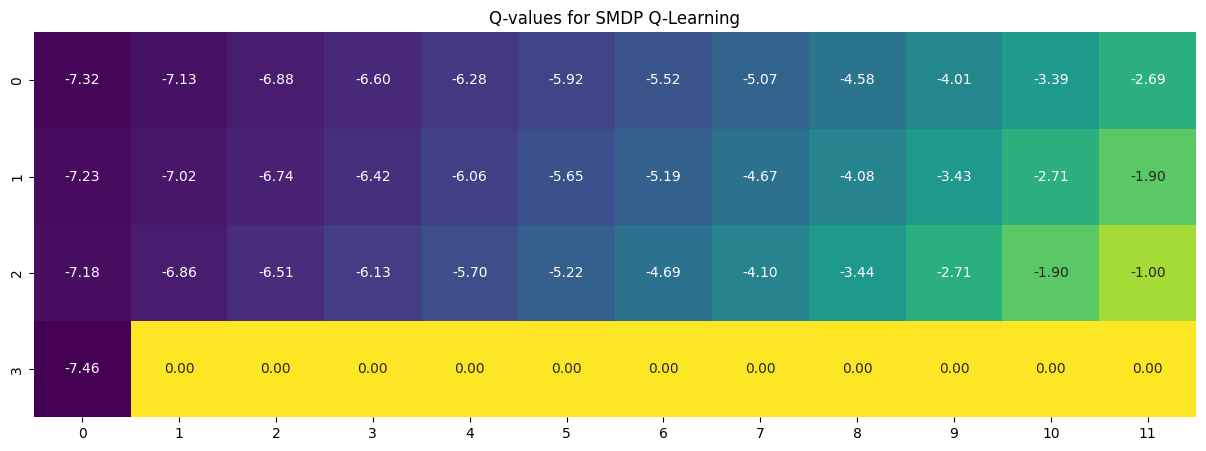

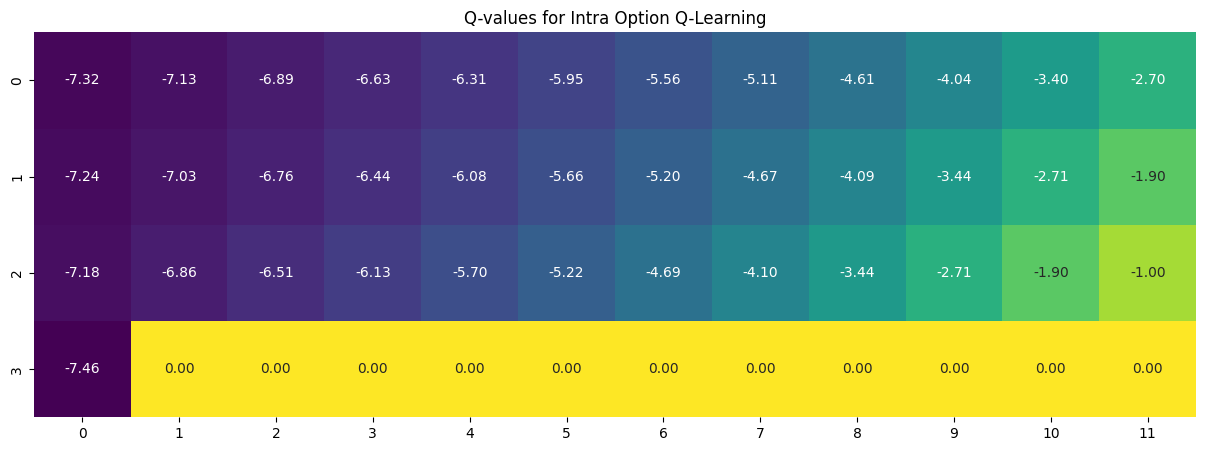

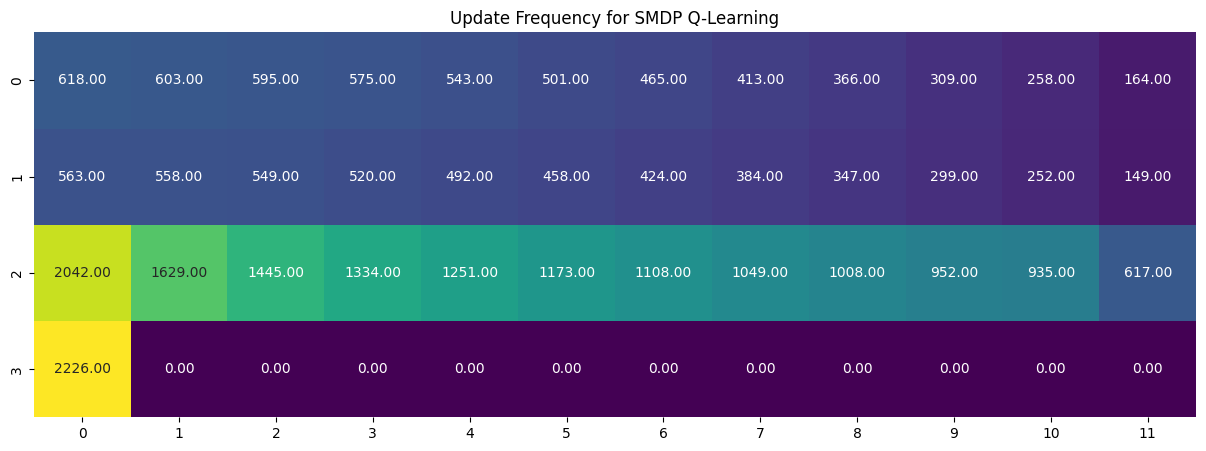

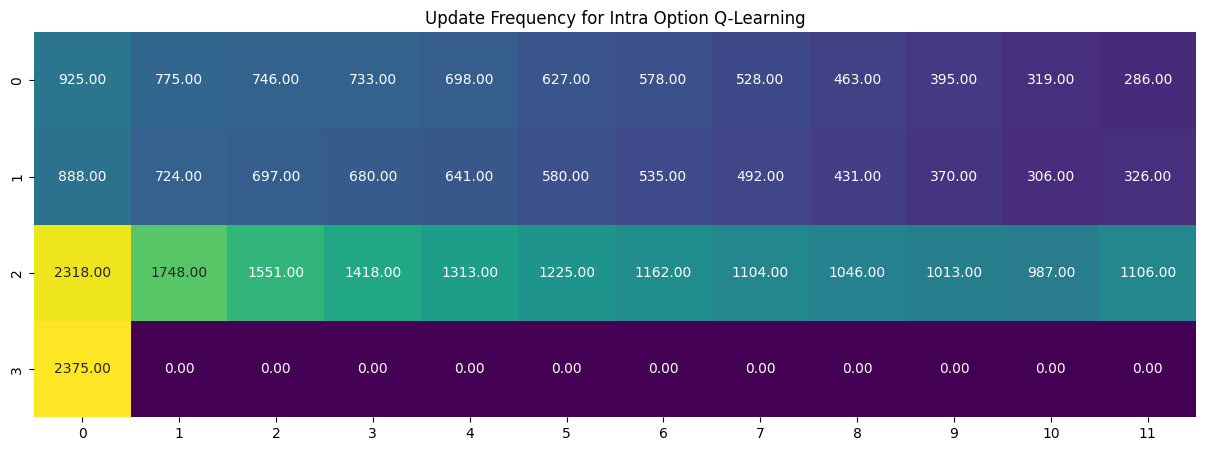

In [7]:
import seaborn as sns

q_values_SMDP_best = np.max(q_values_SMDP, axis=1).reshape(4, 12)
q_values_IOQL_best = np.max(q_values_IOQL, axis=1).reshape(4, 12)

update_freq_IOQL_sum = np.sum(update_freq_IOQL, axis=1).reshape(4, 12)
update_freq_SMDP_sum = np.sum(update_freq_SMDP, axis=1).reshape(4, 12)

plt.figure(figsize=(15, 5))
plt.title("Q-values for SMDP Q-Learning")
sns.heatmap(q_values_SMDP_best, annot=True, fmt=".2f", cbar=False, cmap="viridis")
plt.show()

plt.figure(figsize=(15, 5))
plt.title("Q-values for Intra Option Q-Learning")
sns.heatmap(q_values_IOQL_best, annot=True, fmt=".2f", cbar=False, cmap="viridis")
plt.show()


plt.figure(figsize=(15, 5))
plt.title("Update Frequency for SMDP Q-Learning")
sns.heatmap(update_freq_SMDP_sum, annot=True, fmt=".2f", cbar=False, cmap="viridis")
plt.show()

plt.figure(figsize=(15, 5))
plt.title("Update Frequency for Intra Option Q-Learning")
sns.heatmap(update_freq_IOQL_sum, annot=True, fmt=".2f", cbar=False, cmap="viridis")
plt.show()

**Observations**

-  We observe that the Q-Tables of both SMDP Q-Learning and Intra Option Q-Learning are very similar. However, the differences have a similar pattern.

-  The Q-values of Intra Option Q-Learning are a little more  *extreme* compared to SMDP Q-Learning i.e. states farther from the goal have slightly lower Q-values in Intra Option Q-Learning compared to SMDP Q-Learning. This can be seen be observing the top row of the Q-Table heatmaps. 

- In fact, the Q-values of Intra Option Q-Learning are a little closer to the true Q-values compared to SMDP Q-Learning. 

- The true value is $- \sum_{j=0}^i \gamma^j$ where $j$ is the minimum number of steps to reach the goal from state $i$. The true value array = $[-1, -1.9, -2.71, -3.44, -4.1, -4.69, -5.22, -5.7, -6.13, -6.52, -6.87, -7.19, -7.48]$.

- The above point can be explained by the update frqeuencies of the two algorithms. The update frequencies of Intra Option Q-Learning are higher compared to SMDP Q-Learning. This is because Intra Option Q-Learning updates the Q-Table even when the agent is inside an option, while SMDP Q-Learning updates the Q-Table only on completion of an option (Both policies update when agent takes primitive actions). This can be seen by observing the update frequency heatmaps of the two algorithms.